In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys
from rdkit.Chem import DataStructs
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker
from itertools import product
from sklearn.svm import SVC
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import chi2
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import confusion_matrix
from tensorboard.plugins.hparams import api as hp
from sklearn.model_selection import train_test_split
%load_ext tensorboard
matplotlib.rcParams.update({'font.size': 24})
plt.style.use("ggplot")

PATH_DATA = "../datasets/CYP/"
hyperparam_tunning = False

In [2]:
shared_data = pd.read_csv(os.path.join(PATH_DATA, "shared_set_cyp.csv"))
labels_2c9 = (shared_data["p450-cyp2c9 Activity Outcome"] == "Active").values.astype(int)
labels_3a4 = (shared_data["p450-cyp3a4 Activity Outcome"] == "Active").values.astype(int)
testing_2c9_data = pd.read_csv(os.path.join(PATH_DATA, "only_2c9_set_cyp.csv"))
labels_testing_2c9 = (testing_2c9_data["p450-cyp2c9 Activity Outcome"] == "Active").values.astype(int)
testing_3a4_data = pd.read_csv(os.path.join(PATH_DATA, "only_3a4_set_cyp.csv"))
labels_testing_3a4 = (testing_3a4_data["p450-cyp3a4 Activity Outcome"] == "Active").values.astype(int)

In [3]:
def get_features(input_sdf):
    structures_shared = Chem.SDMolSupplier(input_sdf)
    features = []
    fps = []
    for mol in structures_shared:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol,2,nBits=1024)
        fps.append(fp)
        arr = np.zeros((0,), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(fp,arr)
        features.append(arr)
    return fps, np.array(features)

In [4]:
fps_shared, features_shared = get_features(os.path.join(PATH_DATA, "shared_set_cyp.sdf"))
fps_only_2c9, features_only_2c9 = get_features(os.path.join(PATH_DATA, "only_2c9_set_cyp.sdf"))
fps_only_3a4, features_only_3a4 = get_features(os.path.join(PATH_DATA, "only_3a4_set_cyp.sdf"))
nfps = len(features_shared)

In [5]:
def distij(i,j):
    return 1-DataStructs.DiceSimilarity(fps_shared[i],fps_shared[j])

def disttan(i,j, fps=fps_shared):
    return 1-DataStructs.TanimotoSimilarity(fps[i], fps[j])

[3528, 3373, 4345, 4526, 3976, 4425, 4854, 5556, 4571, 3782, 3822, 4680, 3108, 5010, 2928, 4755, 8892, 4290, 3325, 2648]


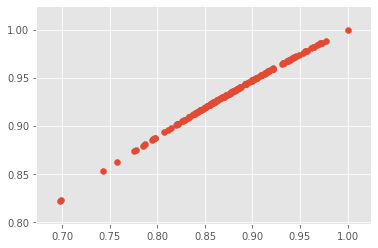

In [6]:
n_mols = 20
picker = MaxMinPicker()
pickIndices = list(picker.LazyBitVectorPick(fps_shared,nfps,n_mols,seed=42))
print(pickIndices)
dists_dice = []
dists_tan = []
for i, ind in enumerate(pickIndices):
    for j in pickIndices[i+1:]:
        dists_dice.append(distij(i, j))
        dists_tan.append(disttan(i, j))
        
plt.scatter(dists_dice, dists_tan)

In [6]:
def print_metrics(predicted_values, target_values):
    tn, fp, fn, tp = confusion_matrix(target_values, predicted_values >= 0.5).ravel()
    Sn = tp/(tp+fn)
    Sp = tn/(tn+fp)
    precision = tp/(tp+fp)
    ner = (Sn+Sp)/2
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    print(f"NER: {ner:.3f}, Sensitivity or recall: {Sn:.3f}, Specificity: {Sp:.3f}, Precision: {precision:.3f}, Correctly classified: {accuracy:.3f}, MCC: {mcc:.3f}")
    return [accuracy, mcc]

def generate_model(n_hidden_layers, n_neurons, dropout_freq, optimizer, L2_val, n_bits):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(n_bits, activation='relu', input_shape=(n_bits,)),tf.keras.layers.Dropout(dropout_freq)]+
        [tf.keras.layers.Dense(n_neurons, kernel_regularizer=tf.keras.regularizers.l2(L2_val),  activation="relu") for _ in range(n_hidden_layers)]+
        [tf.keras.layers.Dense(1, activation="sigmoid")])
    loss_function = tf.keras.losses.BinaryCrossentropy()
    model.compile(optimizer=optimizer, loss=loss_function, metrics=tf.keras.metrics.BinaryAccuracy(name="binary_accuracy"))
    return model

def calculate_similarities(fingerprints, indices):
    distances = []
    for i, ind in enumerate(indices):
        local_dist = []
        for j in indices:
            if ind == j:
                continue
            local_dist.append(disttan(ind, j, fingerprints))
        distances.append(np.mean(local_dist))
    return distances

def test_sizes_set(n_hidden_layers, n_neurons, dropout_freq, optimizer, L2_val, size_list, active_fraction, labels, fingerprints, features, features_only, labels_testing):   
    # columns are: accuracy, MCC
    results_test = []
    results_validation = []
    results_test_diverse = []
    results_validation_diverse = []
    distances_random = []
    distances_diverse = []
    active_indices = np.where(labels == 1)[0]
    inactive_indices = np.where(labels == 0)[0]
    fps_active = [fingerprints[ind] for ind in active_indices]
    fps_inactive = [fingerprints[ind] for ind in inactive_indices]
    n_bits = features.shape[1]
    picker = MaxMinPicker()
    for size in size_list:
        n_actives = int(active_fraction*size)
        if n_actives > len(active_indices):
            n_actives = len(active_indices)
        n_inactives = size-n_actives
        selected_active = np.random.choice(active_indices, size=n_actives, replace=False)
        selected_inactive = np.random.choice(inactive_indices, size=n_inactives, replace=False)
        selected = np.sort(selected_active.tolist()+selected_inactive.tolist())
        distances_random.append(calculate_similarities(fingerprints, selected))
        model = generate_model(n_hidden_layers, n_neurons, dropout_freq, optimizer, L2_val, n_bits)
        train_data, val_data, train_labels, val_labels = train_test_split(features[selected], labels[selected], stratify=labels[selected])
        print("Proportion actives in validation:", np.sum(val_labels)/len(val_labels), "Proportion actives in train:", np.sum(train_labels)/len(train_labels))
        history = model.fit(train_data, train_labels, epochs=10, verbose=0)
        predictions = model.predict(val_data)
        print(f"Metrics with size {size}, {len(selected)}, validation set, random ligands")
        res_val = print_metrics(predictions, val_labels);
        results_validation.append(res_val)
        print(f"Metrics with size {size}, testing set, random ligands")
        predictions = model.predict(features_only)
        res_test = print_metrics(predictions, labels_testing);
        results_test.append(res_test)
        # select diverse molecules
        indices_active = list(picker.LazyBitVectorPick(fps_active,len(fps_active),n_actives,seed=42))
        indices_inactive = list(picker.LazyBitVectorPick(fps_inactive,len(fps_inactive),n_inactives,seed=42))
        selected_active = [active_indices[x] for x in indices_active]
        selected_inactive = [inactive_indices[x] for x in indices_inactive]
        selected = np.sort(selected_active+selected_inactive)
        distances_diverse.append(calculate_similarities(fingerprints, selected.tolist()))
        
        model = generate_model(n_hidden_layers, n_neurons, dropout_freq, optimizer, L2_val, n_bits)
        train_data, val_data, train_labels, val_labels = train_test_split(features[selected], labels[selected], stratify=labels[selected])
        print("Proportion actives in validation:", np.sum(val_labels)/len(val_labels), "Proportion actives in train:", np.sum(train_labels)/len(train_labels))
        history = model.fit(train_data, train_labels, epochs=10, verbose=0)
        predictions = model.predict(val_data)
        print(f"Metrics with size {size}, {len(selected)}, validation set, diverse ligands")
        res_val = print_metrics(predictions, val_labels);
        results_validation_diverse.append(res_val)
        print(f"Metrics with size {size}, testing set, diverse ligands")
        predictions = model.predict(features_only)
        res_test = print_metrics(predictions, labels_testing);
        results_test_diverse.append(res_test)        
    return results_test, results_validation, results_test_diverse, results_validation_diverse, distances_random, distances_diverse

def plot_distances(random_distances, diverse_distances):
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    sns.violinplot(data=random_distances, ax=axes[0])
    axes[0].set(xticklabels=sizes);
    sns.violinplot(data=diverse_distances, ax=axes[1])
    axes[1].set(xticklabels=sizes);
    axes[0].tick_params(axis='x', rotation=90)
    axes[1].tick_params(axis='x', rotation=90)
    axes[0].set_ylabel("Average tanimoto distance")
    axes[0].set_xlabel("Data set size")
    axes[1].set_xlabel("Data set size")
    axes[0].set_title("Random ligands")
    axes[1].set_title("Diverse ligands");
    
def plot_evolution(random_val, diverse_val, random_test, diverse_test):
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    lines = axes[0].plot(sizes, random_val, "x-")
    lines += axes[0].plot(sizes, diverse_val, "o-")
    axes[0].legend(lines, ["Acc. random", "MCC random", "Acc. diverse", "MCC diverse"], fontsize=16)
    axes[0].set_xticklabels(sizes, rotation=90, fontsize=16);
    axes[0].set(xticklabels=sizes);

    lines = axes[1].plot(sizes, random_test, "x-")
    lines += axes[1].plot(sizes, diverse_test, "o-")
    axes[1].legend(lines, ["Acc. random", "MCC random", "Acc. diverse", "MCC diverse"], fontsize=16)
    axes[0].set_xticks(ticks=sizes)
    axes[1].set_xticks(ticks=sizes)
    axes[0].set_xticklabels(sizes, rotation=90, fontsize=14);
    axes[1].set_xticklabels(sizes, rotation=90, fontsize=14);
    # axes[0].set_ylabel("Average tanimoto distance")
    axes[0].grid()
    axes[1].grid()
    axes[0].set_xlabel("Data set size")
    axes[1].set_xlabel("Data set size")
    axes[0].set_title("Validation set")
    axes[1].set_title("Test set"); 

In [8]:
sizes = [100, 300, 500, 800, 1000, 1500, 2000, 3000, 5000, 7000, 9420]
hidden_layers = 8
neurons = 256
dropout = 0.2
lr = 0.1
opt  = tf.keras.optimizers.SGD(lr=lr)
L2 = 0.0010000
isoform_name = "2c9"
active_rate = len(np.where(labels_2c9 == 1)[0])/len(labels_2c9)
test_random, validation_random, test_diverse, validation_diverse, dist_random, dist_diverse = test_sizes_set(hidden_layers, neurons, dropout, opt, L2, sizes, active_rate, labels_2c9, fps_shared, features_shared, features_only_2c9, labels_testing_2c9)

Proportion actives in validation: 0.32 Proportion actives in train: 0.32
Metrics with size 100, 100, validation set, random ligands
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.680, MCC: nan
Metrics with size 100, testing set, random ligands
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.639, MCC: nan


/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


Proportion actives in validation: 0.32 Proportion actives in train: 0.32
Metrics with size 100, 100, validation set, diverse ligands
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.680, MCC: nan
Metrics with size 100, testing set, diverse ligands
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.639, MCC: nan


/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


Proportion actives in validation: 0.32 Proportion actives in train: 0.32
Metrics with size 300, 300, validation set, random ligands
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.680, MCC: nan
Metrics with size 300, testing set, random ligands
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.639, MCC: nan


/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


Proportion actives in validation: 0.32 Proportion actives in train: 0.32
Metrics with size 300, 300, validation set, diverse ligands
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.680, MCC: nan
Metrics with size 300, testing set, diverse ligands
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.639, MCC: nan


/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


Proportion actives in validation: 0.32 Proportion actives in train: 0.32
Metrics with size 500, 500, validation set, random ligands
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.680, MCC: nan
Metrics with size 500, testing set, random ligands
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.639, MCC: nan


/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


Proportion actives in validation: 0.32 Proportion actives in train: 0.32
Metrics with size 500, 500, validation set, diverse ligands
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.680, MCC: nan
Metrics with size 500, testing set, diverse ligands
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.639, MCC: nan


/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


Proportion actives in validation: 0.32 Proportion actives in train: 0.32166666666666666
Metrics with size 800, 800, validation set, random ligands
NER: 0.685, Sensitivity or recall: 0.656, Specificity: 0.713, Precision: 0.519, Correctly classified: 0.695, MCC: 0.351
Metrics with size 800, testing set, random ligands
NER: 0.657, Sensitivity or recall: 0.648, Specificity: 0.666, Precision: 0.523, Correctly classified: 0.659, MCC: 0.303
Proportion actives in validation: 0.32 Proportion actives in train: 0.32166666666666666
Metrics with size 800, 800, validation set, diverse ligands
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.680, MCC: nan
Metrics with size 800, testing set, diverse ligands
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.639, MCC: nan


/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


Proportion actives in validation: 0.32 Proportion actives in train: 0.32133333333333336
Metrics with size 1000, 1000, validation set, random ligands
NER: 0.713, Sensitivity or recall: 0.838, Specificity: 0.588, Precision: 0.489, Correctly classified: 0.668, MCC: 0.399
Metrics with size 1000, testing set, random ligands
NER: 0.646, Sensitivity or recall: 0.865, Specificity: 0.426, Precision: 0.460, Correctly classified: 0.585, MCC: 0.300
Proportion actives in validation: 0.32 Proportion actives in train: 0.32133333333333336
Metrics with size 1000, 1000, validation set, diverse ligands
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.680, MCC: nan
Metrics with size 1000, testing set, diverse ligands
NER: 0.500, Sensitivity or recall: 0.001, Specificity: 1.000, Precision: 1.000, Correctly classified: 0.639, MCC: 0.025


/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


Proportion actives in validation: 0.32 Proportion actives in train: 0.3217777777777778
Metrics with size 1500, 1500, validation set, random ligands
NER: 0.613, Sensitivity or recall: 0.258, Specificity: 0.969, Precision: 0.795, Correctly classified: 0.741, MCC: 0.347
Metrics with size 1500, testing set, random ligands
NER: 0.578, Sensitivity or recall: 0.186, Specificity: 0.971, Precision: 0.781, Correctly classified: 0.687, MCC: 0.268
Proportion actives in validation: 0.32266666666666666 Proportion actives in train: 0.3208888888888889
Metrics with size 1500, 1500, validation set, diverse ligands
NER: 0.558, Sensitivity or recall: 0.975, Specificity: 0.142, Precision: 0.351, Correctly classified: 0.411, MCC: 0.179
Metrics with size 1500, testing set, diverse ligands
NER: 0.511, Sensitivity or recall: 0.991, Specificity: 0.032, Precision: 0.367, Correctly classified: 0.378, MCC: 0.073
Proportion actives in validation: 0.322 Proportion actives in train: 0.32133333333333336
Metrics with s

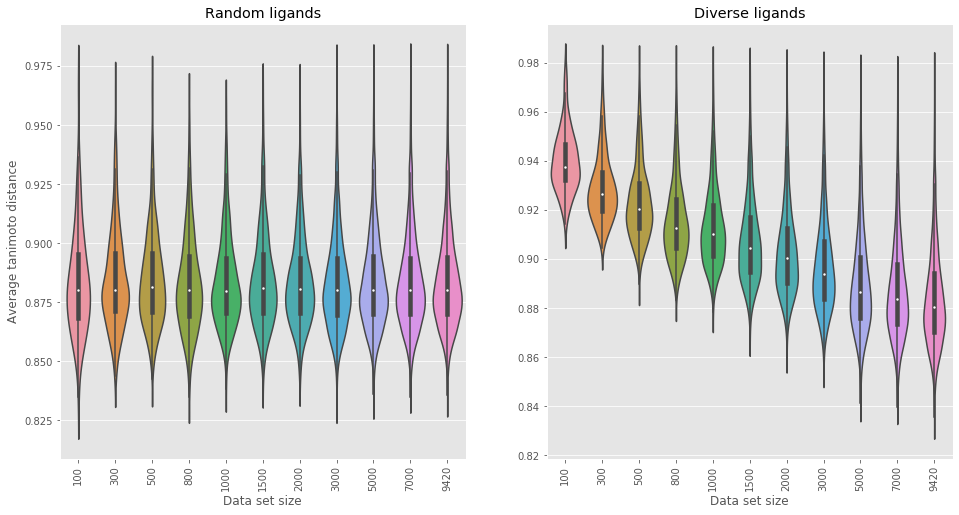

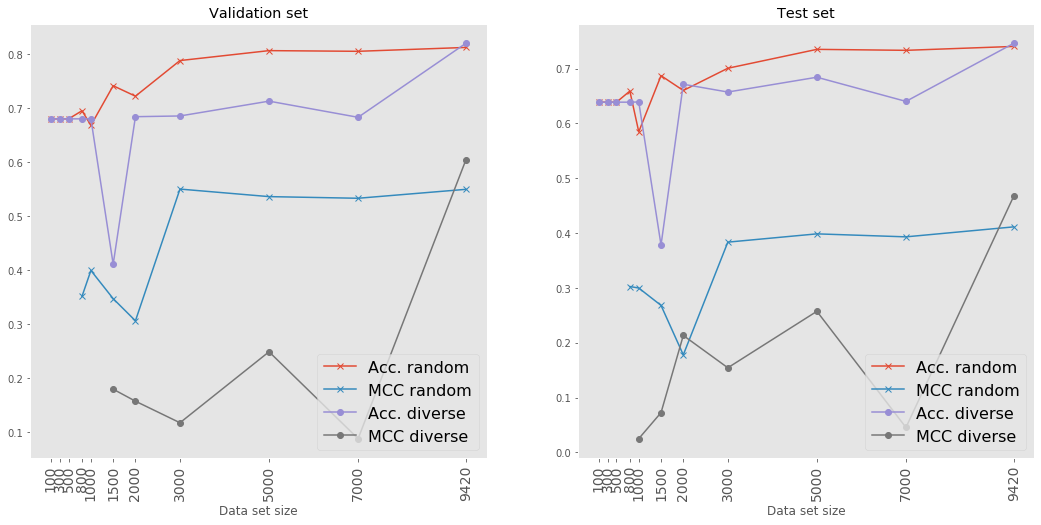

In [9]:
plot_distances(dist_random, dist_diverse)
plot_evolution(validation_random, validation_diverse, test_random, test_diverse)

In [10]:
def calculate_distances_groups(group1, group2):
    return [np.mean([1-DataStructs.TanimotoSimilarity(g1, g2) for g2 in group2]) for g1 in group1] 

In [11]:
picker = MaxMinPicker()
active_indices = np.where(labels_2c9 == 1)[0]
inactive_indices = np.where(labels_2c9 == 0)[0]
fps_active = [fps_shared[ind] for ind in active_indices]
fps_inactive = [fps_shared[ind] for ind in inactive_indices]
active_fraction = len(np.where(labels_2c9 == 1)[0])/len(labels_2c9)

only_2c9_active_indices = np.where(labels_testing_2c9 == 1)[0]
only_2c9_inactive_indices = np.where(labels_testing_2c9 == 0)[0]
only_2c9_fps_active = [fps_only_2c9[ind] for ind in only_2c9_active_indices]
only_2c9_fps_inactive = [fps_only_2c9[ind] for ind in only_2c9_inactive_indices]
only_2c9_active_fraction = len(np.where(labels_testing_2c9 == 1)[0])/len(labels_testing_2c9)

distances_compare_inactive = []
distances_compare_active = []
percentiles = [0.1*i for i in range(1, 11)]
for percent in percentiles:
    size = int(len(labels_2c9)*percent)
    n_actives = int(active_fraction*size)
    if n_actives > len(active_indices):
        n_actives = len(active_indices)
    n_inactives = size-n_actives
    indices_active = list(picker.LazyBitVectorPick(fps_active,len(fps_active),n_actives,seed=42))
    indices_inactive = list(picker.LazyBitVectorPick(fps_inactive,len(fps_inactive),n_inactives,seed=42))
    active_shared = [fps_active[i] for i in indices_active]
    inactive_shared = [fps_inactive[i] for i in indices_inactive]
    
    only_2c9_size = int(only_2c9_active_fraction*percent)
    only_2c9_n_actives = int(only_2c9_active_fraction*only_2c9_size)
    if only_2c9_n_actives > len(only_2c9_active_indices):
        only_2c9_n_actives = len(only_2c9_active_indices)
    only_2c9_n_inactives = only_2c9_size-only_2c9_n_actives
    only_2c9_indices_active = list(picker.LazyBitVectorPick(only_2c9_fps_active,len(only_2c9_fps_active),only_2c9_n_actives,seed=42))
    only_2c9_indices_inactive = list(picker.LazyBitVectorPick(only_2c9_fps_inactive,len(only_2c9_fps_inactive),only_2c9_n_inactives,seed=42))
    only_2c9_active = [only_2c9_fps_active[i] for i in only_2c9_indices_active]
    only_2c9_inactive = [only_2c9_fps_inactive[i] for i in only_2c9_indices_inactive]
    
    distances_compare_active.append(calculate_distances_groups(active_shared, only_2c9_active))
    distances_compare_inactive.append(calculate_distances_groups(inactive_shared, only_2c9_inactive))

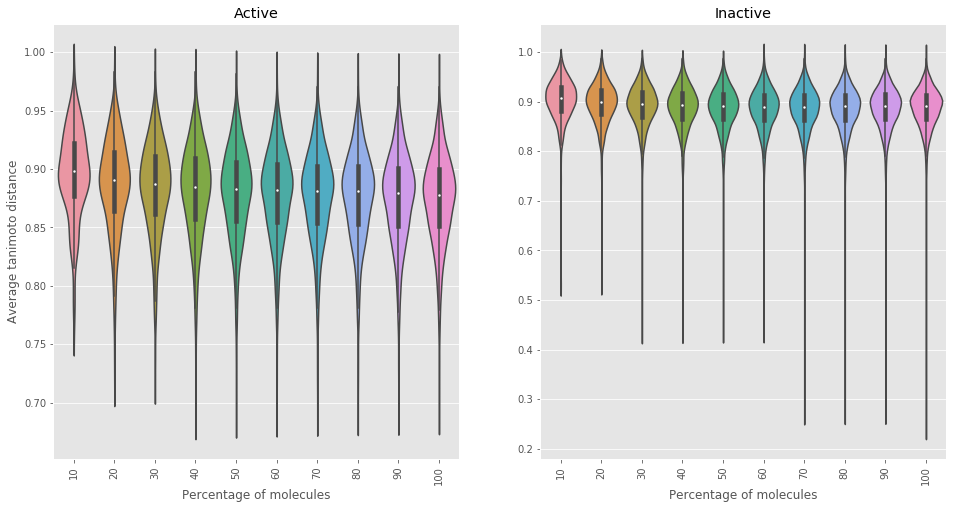

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
sns.violinplot(data=distances_compare_active, ax=axes[0])
axes[0].set(xticklabels=[int(100*p) for p in percentiles]);
sns.violinplot(data=distances_compare_inactive, ax=axes[1])
axes[1].set(xticklabels=[int(100*p) for p in percentiles]);
axes[0].tick_params(axis='x', rotation=90)
axes[1].tick_params(axis='x', rotation=90)
axes[0].set_ylabel("Average tanimoto distance")
axes[0].set_xlabel("Percentage of molecules")
axes[1].set_xlabel("Percentage of molecules")
axes[0].set_title("Active")
axes[1].set_title("Inactive");

In [13]:
sizes = [100, 300, 500, 800, 1000, 1500, 2000, 3000, 5000, 7000, 9420]
hidden_layers = 8
neurons = 256
dropout = 0.2
lr = 0.1
opt  = tf.keras.optimizers.SGD(lr=lr)
L2 = 0.0010000
isoform_name = "2c9"
active_rate = 0.5
test_random_balanced, validation_random_balanced, test_diverse_balanced, validation_diverse_balanced, dist_random_balanced, dist_diverse_balanced = test_sizes_set(hidden_layers, neurons, dropout, opt, L2, sizes, active_rate, labels_2c9, fps_shared, features_shared, features_only_2c9, labels_testing_2c9)

Proportion actives in validation: 0.48 Proportion actives in train: 0.5066666666666667
Metrics with size 100, 100, validation set, random ligands
NER: 0.510, Sensitivity or recall: 0.250, Specificity: 0.769, Precision: 0.500, Correctly classified: 0.520, MCC: 0.022
Metrics with size 100, testing set, random ligands
NER: 0.532, Sensitivity or recall: 0.315, Specificity: 0.748, Precision: 0.415, Correctly classified: 0.592, MCC: 0.068
Proportion actives in validation: 0.52 Proportion actives in train: 0.49333333333333335
Metrics with size 100, 100, validation set, diverse ligands
NER: 0.542, Sensitivity or recall: 1.000, Specificity: 0.083, Precision: 0.542, Correctly classified: 0.560, MCC: 0.212
Metrics with size 100, testing set, diverse ligands
NER: 0.502, Sensitivity or recall: 0.996, Specificity: 0.007, Precision: 0.362, Correctly classified: 0.364, MCC: 0.020
Proportion actives in validation: 0.5066666666666667 Proportion actives in train: 0.49777777777777776
Metrics with size 300

/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


Proportion actives in validation: 0.49333333333333335 Proportion actives in train: 0.5022222222222222
Metrics with size 300, 300, validation set, diverse ligands
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.493, Correctly classified: 0.493, MCC: nan
Metrics with size 300, testing set, diverse ligands
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.361, Correctly classified: 0.361, MCC: nan


/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


Proportion actives in validation: 0.496 Proportion actives in train: 0.5013333333333333
Metrics with size 500, 500, validation set, random ligands
NER: 0.595, Sensitivity or recall: 0.984, Specificity: 0.206, Precision: 0.550, Correctly classified: 0.592, MCC: 0.302
Metrics with size 500, testing set, random ligands
NER: 0.540, Sensitivity or recall: 0.973, Specificity: 0.107, Precision: 0.381, Correctly classified: 0.420, MCC: 0.145
Proportion actives in validation: 0.504 Proportion actives in train: 0.49866666666666665
Metrics with size 500, 500, validation set, diverse ligands
NER: 0.531, Sensitivity or recall: 0.143, Specificity: 0.919, Precision: 0.643, Correctly classified: 0.528, MCC: 0.099
Metrics with size 500, testing set, diverse ligands
NER: 0.611, Sensitivity or recall: 0.514, Specificity: 0.709, Precision: 0.500, Correctly classified: 0.638, MCC: 0.221
Proportion actives in validation: 0.5 Proportion actives in train: 0.5
Metrics with size 800, 800, validation set, random

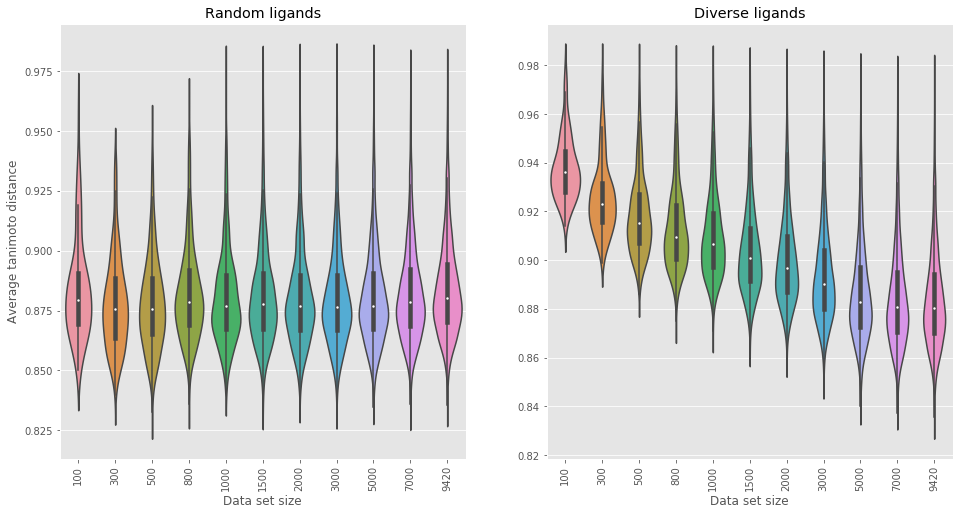

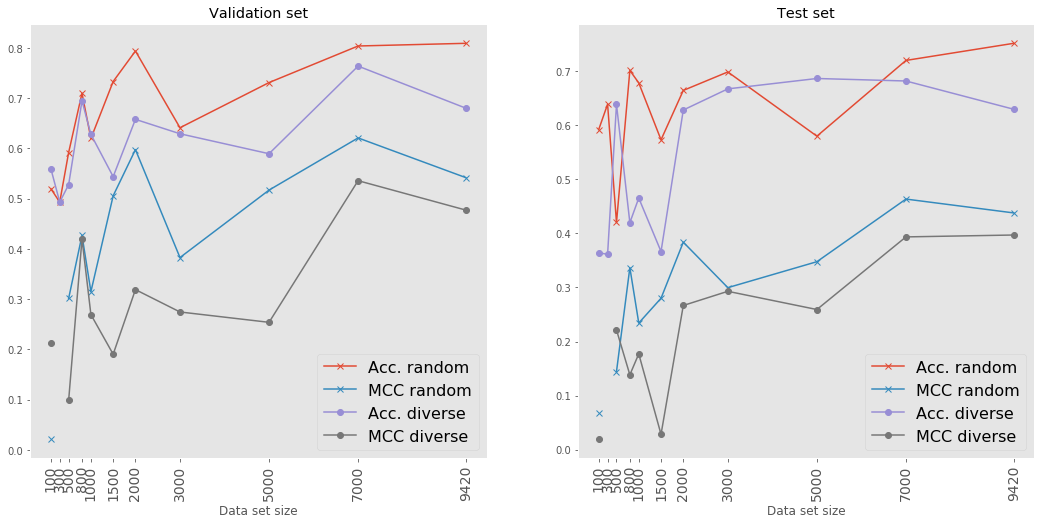

In [14]:
plot_distances(dist_random_balanced, dist_diverse_balanced)
plot_evolution(validation_random_balanced, validation_diverse_balanced, test_random_balanced, test_diverse_balanced)

Try with SVM

In [15]:
def test_sizes_set_SVM(size_list, active_fraction, labels, fingerprints, features, features_only, labels_testing):   
    # columns are: accuracy, MCC
    results_test = []
    results_validation = []
    results_test_diverse = []
    results_validation_diverse = []
    distances_random = []
    distances_diverse = []
    active_indices = np.where(labels == 1)[0]
    inactive_indices = np.where(labels == 0)[0]
    fps_active = [fingerprints[ind] for ind in active_indices]
    fps_inactive = [fingerprints[ind] for ind in inactive_indices]
    picker = MaxMinPicker()
    for size in size_list:
        n_actives = int(active_fraction*size)
        if n_actives > len(active_indices):
            n_actives = len(active_indices)
        n_inactives = size-n_actives
        selected_active = np.random.choice(active_indices, size=n_actives, replace=False)
        selected_inactive = np.random.choice(inactive_indices, size=n_inactives, replace=False)
        selected = np.sort(selected_active.tolist()+selected_inactive.tolist())
        distances_random.append(calculate_similarities(fingerprints, selected))
        model = SVC(C=20, kernel="rbf")
        train_data, val_data, train_labels, val_labels = train_test_split(features[selected], labels[selected], stratify=labels[selected])
        print("Proportion actives in validation:", np.sum(val_labels)/len(val_labels), "Proportion actives in train:", np.sum(train_labels)/len(train_labels))
        history = model.fit(train_data, train_labels)
        predictions = model.predict(val_data)
        print(f"Metrics with size {size}, validation set, random ligands")
        res_val = print_metrics(predictions, val_labels);
        results_validation.append(res_val)
        print(f"Metrics with size {size}, testing set, random ligands")
        predictions = model.predict(features_only)
        res_test = print_metrics(predictions, labels_testing);
        results_test.append(res_test)
        # select diverse molecules
        indices_active = list(picker.LazyBitVectorPick(fps_active,len(fps_active),n_actives,seed=42))
        indices_inactive = list(picker.LazyBitVectorPick(fps_inactive,len(fps_inactive),n_inactives,seed=42))
        selected_active = [active_indices[x] for x in indices_active]
        selected_inactive = [inactive_indices[x] for x in indices_inactive]
        selected = np.sort(selected_active+selected_inactive)
        distances_diverse.append(calculate_similarities(fingerprints, selected.tolist()))
        
        model = SVC(C=20, kernel="rbf")        
        train_data, val_data, train_labels, val_labels = train_test_split(features[selected], labels[selected], stratify=labels[selected])
        print("Proportion actives in validation:", np.sum(val_labels)/len(val_labels), "Proportion actives in train:", np.sum(train_labels)/len(train_labels))
        history = model.fit(train_data, train_labels)
        predictions = model.predict(val_data)
        print(f"Metrics with size {size}, validation set, diverse ligands")
        res_val = print_metrics(predictions, val_labels);
        results_validation_diverse.append(res_val)
        print(f"Metrics with size {size}, testing set, diverse ligands")
        predictions = model.predict(features_only)
        res_test = print_metrics(predictions, labels_testing);
        results_test_diverse.append(res_test)        
    return results_test, results_validation, results_test_diverse, results_validation_diverse, distances_random, distances_diverse

In [16]:
sizes = [100, 300, 500, 800, 1000, 1500, 2000, 3000, 5000, 7000, 9420]
isoform_name = "2c9"
active_rate = len(np.where(labels_2c9 == 1)[0])/len(labels_2c9)
test_random_SVM, validation_random_SVM, test_diverse_SVM, validation_diverse_SVM, dist_random_SVM, dist_diverse_SVM = test_sizes_set_SVM(sizes, active_rate, labels_2c9, fps_shared, features_shared, features_only_2c9, labels_testing_2c9)

Proportion actives in validation: 0.32 Proportion actives in train: 0.32
Metrics with size 100, validation set, random ligands
NER: 0.596, Sensitivity or recall: 0.250, Specificity: 0.941, Precision: 0.667, Correctly classified: 0.720, MCC: 0.274
Metrics with size 100, testing set, random ligands
NER: 0.546, Sensitivity or recall: 0.162, Specificity: 0.930, Precision: 0.569, Correctly classified: 0.653, MCC: 0.147
Proportion actives in validation: 0.32 Proportion actives in train: 0.32
Metrics with size 100, validation set, diverse ligands
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.680, MCC: nan
Metrics with size 100, testing set, diverse ligands


/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


NER: 0.546, Sensitivity or recall: 0.184, Specificity: 0.908, Precision: 0.530, Correctly classified: 0.646, MCC: 0.133
Proportion actives in validation: 0.32 Proportion actives in train: 0.32
Metrics with size 300, validation set, random ligands
NER: 0.619, Sensitivity or recall: 0.375, Specificity: 0.863, Precision: 0.562, Correctly classified: 0.707, MCC: 0.271
Metrics with size 300, testing set, random ligands
NER: 0.570, Sensitivity or recall: 0.252, Specificity: 0.889, Precision: 0.561, Correctly classified: 0.659, MCC: 0.183
Proportion actives in validation: 0.32 Proportion actives in train: 0.32
Metrics with size 300, validation set, diverse ligands
NER: 0.442, Sensitivity or recall: 0.042, Specificity: 0.843, Precision: 0.111, Correctly classified: 0.587, MCC: -0.165
Metrics with size 300, testing set, diverse ligands
NER: 0.570, Sensitivity or recall: 0.340, Specificity: 0.800, Precision: 0.489, Correctly classified: 0.633, MCC: 0.154
Proportion actives in validation: 0.32 Pr

NER: 0.739, Sensitivity or recall: 0.634, Specificity: 0.845, Precision: 0.698, Correctly classified: 0.769, MCC: 0.490
Proportion actives in validation: 0.3214437367303609 Proportion actives in train: 0.321585279547063
Metrics with size 9420, validation set, diverse ligands
NER: 0.786, Sensitivity or recall: 0.676, Specificity: 0.896, Precision: 0.755, Correctly classified: 0.825, MCC: 0.590
Metrics with size 9420, testing set, diverse ligands
NER: 0.731, Sensitivity or recall: 0.633, Specificity: 0.829, Precision: 0.677, Correctly classified: 0.758, MCC: 0.469


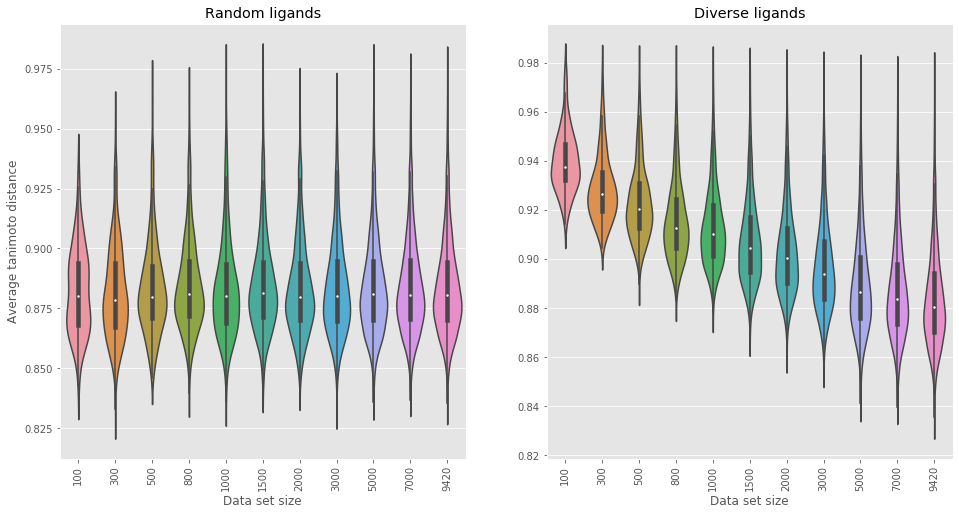

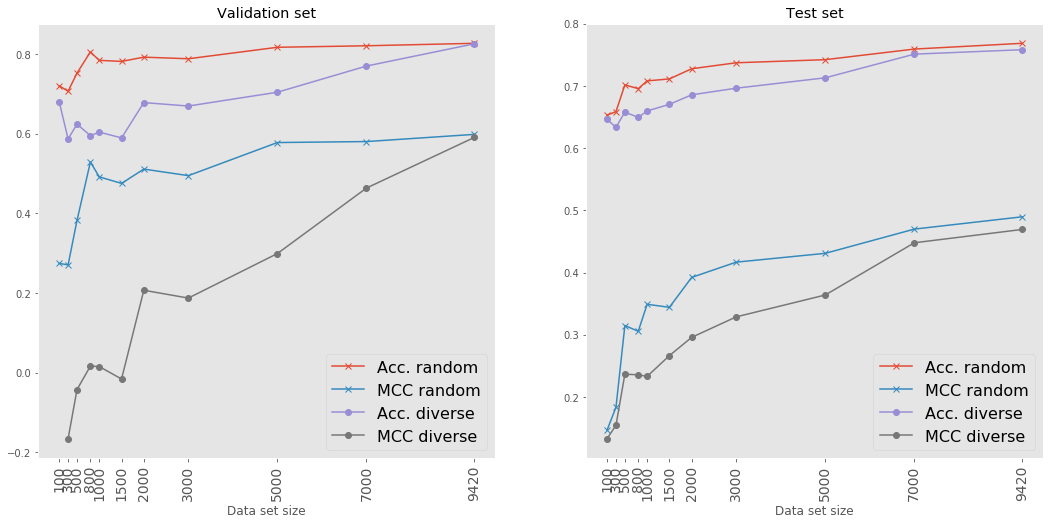

In [17]:
plot_distances(dist_random_SVM, dist_diverse_SVM)
plot_evolution(validation_random_SVM, validation_diverse_SVM, test_random_SVM, test_diverse_SVM)

Now we try with MACCS fingerprints

In [7]:
def get_features_MACCS(input_sdf):
    structures_shared = Chem.SDMolSupplier(input_sdf)
    features = []
    fps = []
    for mol in structures_shared:
        fp = MACCSkeys.GenMACCSKeys(mol)
        fps.append(fp)
        arr = np.zeros((0,), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(fp,arr)
        features.append(arr)
    return fps, np.array(features)

In [8]:
fps_shared_MACCS, features_shared_MACCS = get_features_MACCS(os.path.join(PATH_DATA, "shared_set_cyp.sdf"))
fps_only_2c9_MACCS, features_only_2c9_MACCS = get_features_MACCS(os.path.join(PATH_DATA, "only_2c9_set_cyp.sdf"))
fps_only_3a4_MACCS, features_only_3a4_MACCS = get_features_MACCS(os.path.join(PATH_DATA, "only_3a4_set_cyp.sdf"))
nfps_MACCS = len(features_shared_MACCS)

In [20]:
hidden_layers = 4
neurons = 150
dropout = 0.2
lr = 0.001
# opt  = tf.keras.optimizers.Adam(lr=lr)
opt  = tf.keras.optimizers.Adam()
L2 = 0.001
isoform_name = "2c9"
active_rate = len(np.where(labels_2c9 == 1)[0])/len(labels_2c9)
test_random, validation_random, test_diverse, validation_diverse, dist_random, dist_diverse = test_sizes_set(hidden_layers, neurons, dropout, opt, L2, sizes, active_rate, labels_2c9, fps_shared_MACCS, features_shared_MACCS, features_only_2c9_MACCS, labels_testing_2c9)

Proportion actives in validation: 0.32 Proportion actives in train: 0.32
Metrics with size 100, 100, validation set, random ligands
NER: 0.721, Sensitivity or recall: 0.500, Specificity: 0.941, Precision: 0.800, Correctly classified: 0.800, MCC: 0.514
Metrics with size 100, testing set, random ligands
NER: 0.578, Sensitivity or recall: 0.392, Specificity: 0.763, Precision: 0.484, Correctly classified: 0.629, MCC: 0.164
Proportion actives in validation: 0.32 Proportion actives in train: 0.32
Metrics with size 100, 100, validation set, diverse ligands
NER: 0.603, Sensitivity or recall: 0.500, Specificity: 0.706, Precision: 0.444, Correctly classified: 0.640, MCC: 0.200
Metrics with size 100, testing set, diverse ligands
NER: 0.589, Sensitivity or recall: 0.356, Specificity: 0.821, Precision: 0.529, Correctly classified: 0.653, MCC: 0.198
Proportion actives in validation: 0.32 Proportion actives in train: 0.32
Metrics with size 300, 300, validation set, random ligands
NER: 0.589, Sensitiv

Proportion actives in validation: 0.3211428571428571 Proportion actives in train: 0.32152380952380955
Metrics with size 7000, 7000, validation set, diverse ligands
NER: 0.708, Sensitivity or recall: 0.543, Specificity: 0.874, Precision: 0.670, Correctly classified: 0.767, MCC: 0.443
Metrics with size 7000, testing set, diverse ligands
NER: 0.681, Sensitivity or recall: 0.526, Specificity: 0.837, Precision: 0.646, Correctly classified: 0.724, MCC: 0.382
Proportion actives in validation: 0.3214437367303609 Proportion actives in train: 0.321585279547063
Metrics with size 9420, 9420, validation set, random ligands
NER: 0.767, Sensitivity or recall: 0.655, Specificity: 0.879, Precision: 0.720, Correctly classified: 0.807, MCC: 0.549
Metrics with size 9420, testing set, random ligands
NER: 0.709, Sensitivity or recall: 0.572, Specificity: 0.846, Precision: 0.678, Correctly classified: 0.747, MCC: 0.437
Proportion actives in validation: 0.3214437367303609 Proportion actives in train: 0.321585

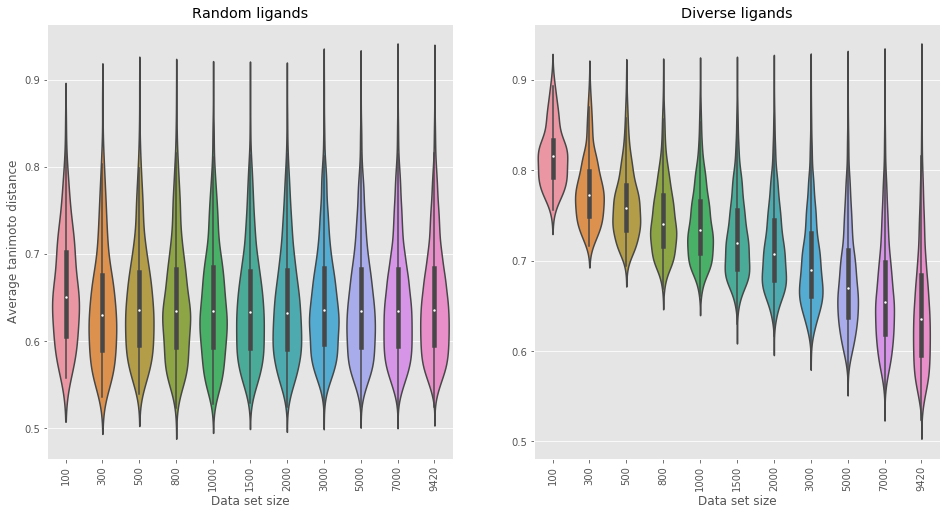

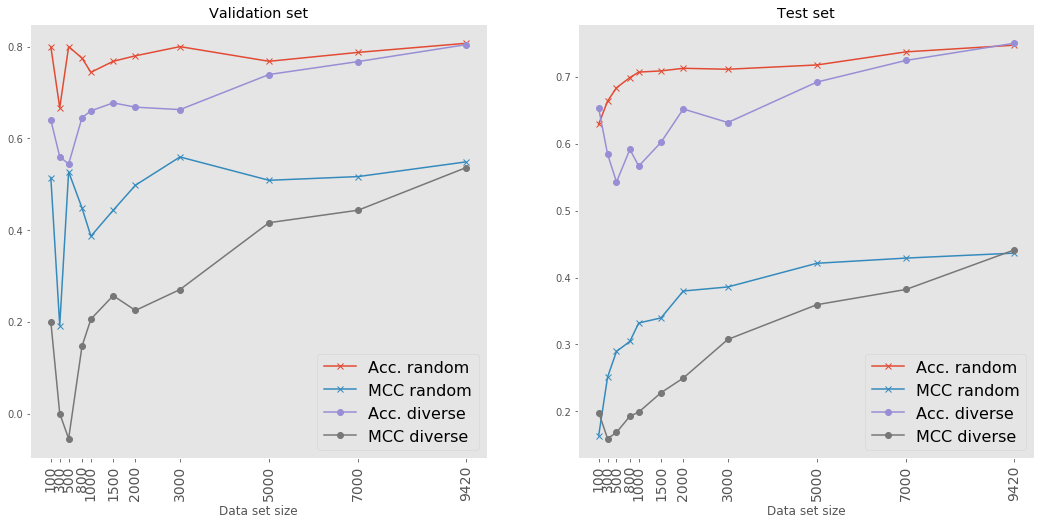

In [21]:
plot_distances(dist_random, dist_diverse)
plot_evolution(validation_random, validation_diverse, test_random, test_diverse)

An we do the same with RDKIT fingerprints

In [9]:
def get_features_RDKIT(input_sdf):
    structures_shared = Chem.SDMolSupplier(input_sdf)
    features = []
    fps = []
    ids = []
    for mol in structures_shared:
        fp = Chem.RDKFingerprint(mol)
        fps.append(fp)
        arr = np.zeros((0,), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(fp,arr)
        features.append(arr)
    return fps, np.array(features)

In [10]:
fps_shared_RDKIT, features_shared_RDKIT = get_features_RDKIT(os.path.join(PATH_DATA, "shared_set_cyp.sdf"))
fps_only_2c9_RDKIT, features_only_2c9_RDKIT = get_features_RDKIT(os.path.join(PATH_DATA, "only_2c9_set_cyp.sdf"))
fps_only_3a4_RDKIT, features_only_3a4_RDKIT = get_features_RDKIT(os.path.join(PATH_DATA, "only_3a4_set_cyp.sdf"))
nfps_RDKIT = len(features_shared_RDKIT)

In [24]:
hidden_layers = 4
neurons = 130
dropout = 0.2
lr = 0.1
opt  = tf.keras.optimizers.SGD(lr=lr)
L2 = 0.0010000

active_rate = len(np.where(labels_2c9 == 1)[0])/len(labels_2c9)
test_random, validation_random, test_diverse, validation_diverse, dist_random, dist_diverse = test_sizes_set(hidden_layers, neurons, dropout, opt, L2, sizes, active_rate, labels_2c9, fps_shared_RDKIT, features_shared_RDKIT, features_only_2c9_RDKIT, labels_testing_2c9)

Proportion actives in validation: 0.32 Proportion actives in train: 0.32
Metrics with size 100, 100, validation set, random ligands
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.680, MCC: nan
Metrics with size 100, testing set, random ligands


/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.639, MCC: nan
Proportion actives in validation: 0.32 Proportion actives in train: 0.32
Metrics with size 100, 100, validation set, diverse ligands
NER: 0.533, Sensitivity or recall: 0.125, Specificity: 0.941, Precision: 0.500, Correctly classified: 0.680, MCC: 0.114
Metrics with size 100, testing set, diverse ligands
NER: 0.538, Sensitivity or recall: 0.859, Specificity: 0.216, Precision: 0.383, Correctly classified: 0.449, MCC: 0.093
Proportion actives in validation: 0.32 Proportion actives in train: 0.32
Metrics with size 300, 300, validation set, random ligands
NER: 0.539, Sensitivity or recall: 1.000, Specificity: 0.078, Precision: 0.338, Correctly classified: 0.373, MCC: 0.163
Metrics with size 300, testing set, random ligands
NER: 0.505, Sensitivity or recall: 0.994, Specificity: 0.015, Precision: 0.363, Correctly classified: 0.369, MCC: 0.041
Proportion actives in validation: 0.

/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


NER: 0.500, Sensitivity or recall: 0.001, Specificity: 1.000, Precision: 1.000, Correctly classified: 0.639, MCC: 0.025
Proportion actives in validation: 0.3211428571428571 Proportion actives in train: 0.32152380952380955
Metrics with size 7000, 7000, validation set, diverse ligands
NER: 0.728, Sensitivity or recall: 0.607, Specificity: 0.850, Precision: 0.657, Correctly classified: 0.772, MCC: 0.467
Metrics with size 7000, testing set, diverse ligands
NER: 0.696, Sensitivity or recall: 0.560, Specificity: 0.832, Precision: 0.653, Correctly classified: 0.734, MCC: 0.407
Proportion actives in validation: 0.3214437367303609 Proportion actives in train: 0.321585279547063
Metrics with size 9420, 9420, validation set, random ligands
NER: 0.774, Sensitivity or recall: 0.687, Specificity: 0.862, Precision: 0.702, Correctly classified: 0.806, MCC: 0.552
Metrics with size 9420, testing set, random ligands
NER: 0.716, Sensitivity or recall: 0.622, Specificity: 0.811, Precision: 0.650, Correctly 

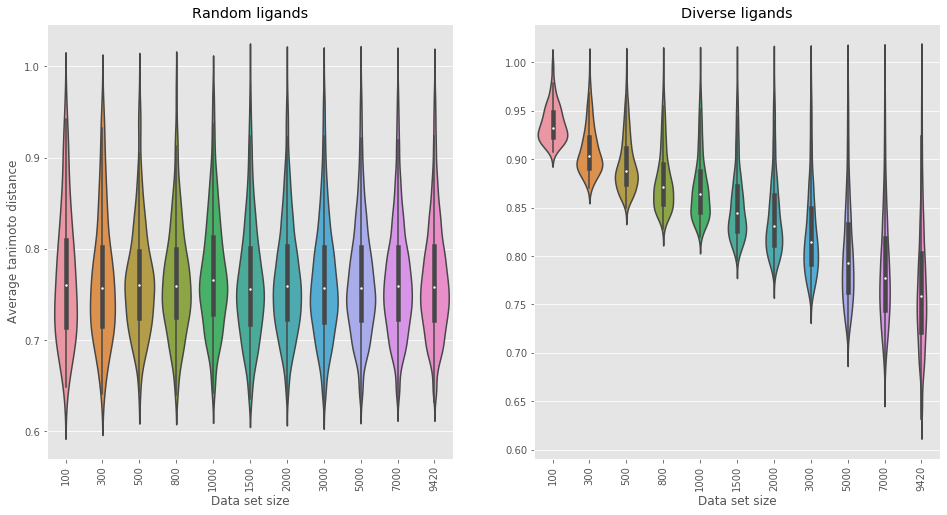

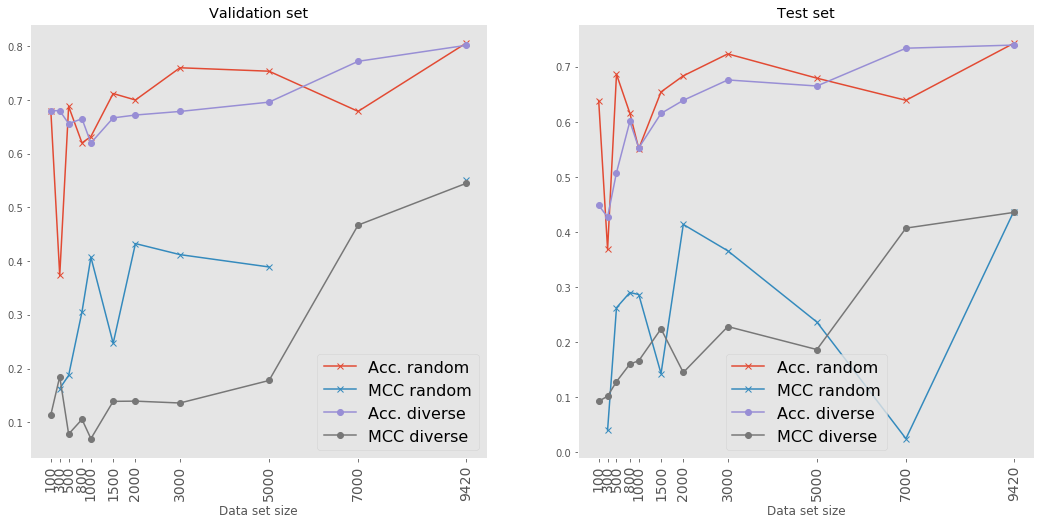

In [25]:
plot_distances(dist_random, dist_diverse)
plot_evolution(validation_random, validation_diverse, test_random, test_diverse)

In [19]:
def test_sizes_set_features_selection(n_hidden_layers, n_neurons, dropout_freq, optimizer, L2_val, size_list, active_fraction, labels, fingerprints, features, features_only, labels_testing, percentile):   
    # columns are: accuracy, MCC
    results_test = []
    results_validation = []
    results_test_diverse = []
    results_validation_diverse = []
    distances_random = []
    distances_diverse = []
    active_indices = np.where(labels == 1)[0]
    inactive_indices = np.where(labels == 0)[0]
    fps_active = [fingerprints[ind] for ind in active_indices]
    fps_inactive = [fingerprints[ind] for ind in inactive_indices]
    feat_select = SelectPercentile(chi2, percentile=percentile)
    transform_features = feat_select.fit_transform(features, labels)
    features_only_transform = feat_select.transform(features_only)
    n_bits = transform_features.shape[1]
    picker = MaxMinPicker()
    print(f"*** Using top {percentile}% features, {transform_features.shape[1]} out of {features.shape[1]}")
    for size in size_list:
        n_actives = int(active_fraction*size)
        if n_actives > len(active_indices):
            n_actives = len(active_indices)
        n_inactives = size-n_actives
        selected_active = np.random.choice(active_indices, size=n_actives, replace=False)
        selected_inactive = np.random.choice(inactive_indices, size=n_inactives, replace=False)
        selected = np.sort(selected_active.tolist()+selected_inactive.tolist())
        distances_random.append(calculate_similarities(fingerprints, selected))
        model = generate_model(n_hidden_layers, n_neurons, dropout_freq, optimizer, L2_val, n_bits)
        train_data, val_data, train_labels, val_labels = train_test_split(transform_features[selected], labels[selected], stratify=labels[selected])
        print("Proportion actives in validation:", np.sum(val_labels)/len(val_labels), "Proportion actives in train:", np.sum(train_labels)/len(train_labels))
        history = model.fit(train_data, train_labels, epochs=10, verbose=0)
        predictions = model.predict(val_data)
        print(f"Metrics with size {size}, {len(selected)}, validation set, random ligands")
        res_val = print_metrics(predictions, val_labels);
        results_validation.append(res_val)
        print(f"Metrics with size {size}, testing set, random ligands")
        predictions = model.predict(features_only_transform)
        res_test = print_metrics(predictions, labels_testing);
        results_test.append(res_test)
        # select diverse molecules
        indices_active = list(picker.LazyBitVectorPick(fps_active,len(fps_active),n_actives,seed=42))
        indices_inactive = list(picker.LazyBitVectorPick(fps_inactive,len(fps_inactive),n_inactives,seed=42))
        selected_active = [active_indices[x] for x in indices_active]
        selected_inactive = [inactive_indices[x] for x in indices_inactive]
        selected = np.sort(selected_active+selected_inactive)
        distances_diverse.append(calculate_similarities(fingerprints, selected.tolist()))
        
        model = generate_model(n_hidden_layers, n_neurons, dropout_freq, optimizer, L2_val, n_bits)
        train_data, val_data, train_labels, val_labels = train_test_split(transform_features[selected], labels[selected], stratify=labels[selected])
        print("Proportion actives in validation:", np.sum(val_labels)/len(val_labels), "Proportion actives in train:", np.sum(train_labels)/len(train_labels))
        history = model.fit(train_data, train_labels, epochs=10, verbose=0)
        predictions = model.predict(val_data)
        print(f"Metrics with size {size}, {len(selected)}, validation set, diverse ligands")
        res_val = print_metrics(predictions, val_labels);
        results_validation_diverse.append(res_val)
        print(f"Metrics with size {size}, testing set, diverse ligands")
        predictions = model.predict(features_only_transform)
        res_test = print_metrics(predictions, labels_testing);
        results_test_diverse.append(res_test)        
    return results_test, results_validation, results_test_diverse, results_validation_diverse, distances_random, distances_diverse


Morgan fingerpritns with features selection

In [20]:
sizes = [100, 300, 500, 800, 1000, 1500, 2000, 3000, 5000, 7000, 9420]
hidden_layers = 8
neurons = 256
dropout = 0.2
lr = 0.1
opt  = tf.keras.optimizers.SGD(lr=lr)
L2 = 0.0010000
isoform_name = "2c9"
active_rate = len(np.where(labels_2c9 == 1)[0])/len(labels_2c9)
test_random, validation_random, test_diverse, validation_diverse, dist_random, dist_diverse = test_sizes_set_features_selection(hidden_layers, neurons, dropout, opt, L2, sizes, active_rate, labels_2c9, fps_shared, features_shared, features_only_2c9, labels_testing_2c9, 40)

*** Using top 40% features, 410 out of 1024
Proportion actives in validation: 0.32 Proportion actives in train: 0.32
Metrics with size 100, 100, validation set, random ligands
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.680, MCC: nan
Metrics with size 100, testing set, random ligands


/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.639, MCC: nan
Proportion actives in validation: 0.32 Proportion actives in train: 0.32
Metrics with size 100, 100, validation set, diverse ligands
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.680, MCC: nan
Metrics with size 100, testing set, diverse ligands
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.639, MCC: nan


/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


Proportion actives in validation: 0.32 Proportion actives in train: 0.32
Metrics with size 300, 300, validation set, random ligands
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.680, MCC: nan
Metrics with size 300, testing set, random ligands
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.639, MCC: nan


/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


Proportion actives in validation: 0.32 Proportion actives in train: 0.32
Metrics with size 300, 300, validation set, diverse ligands
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.680, MCC: nan
Metrics with size 300, testing set, diverse ligands
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.639, MCC: nan


/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


Proportion actives in validation: 0.32 Proportion actives in train: 0.32
Metrics with size 500, 500, validation set, random ligands
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.680, MCC: nan
Metrics with size 500, testing set, random ligands
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.639, MCC: nan


/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


Proportion actives in validation: 0.32 Proportion actives in train: 0.32
Metrics with size 500, 500, validation set, diverse ligands
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.680, MCC: nan
Metrics with size 500, testing set, diverse ligands
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.639, MCC: nan


/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


Proportion actives in validation: 0.32 Proportion actives in train: 0.32166666666666666
Metrics with size 800, 800, validation set, random ligands
NER: 0.528, Sensitivity or recall: 0.062, Specificity: 0.993, Precision: 0.800, Correctly classified: 0.695, MCC: 0.165
Metrics with size 800, testing set, random ligands
NER: 0.525, Sensitivity or recall: 0.064, Specificity: 0.986, Precision: 0.722, Correctly classified: 0.653, MCC: 0.137
Proportion actives in validation: 0.32 Proportion actives in train: 0.32166666666666666
Metrics with size 800, 800, validation set, diverse ligands
NER: 0.508, Sensitivity or recall: 0.016, Specificity: 1.000, Precision: 1.000, Correctly classified: 0.685, MCC: 0.103
Metrics with size 800, testing set, diverse ligands
NER: 0.506, Sensitivity or recall: 0.013, Specificity: 0.998, Precision: 0.812, Correctly classified: 0.642, MCC: 0.071
Proportion actives in validation: 0.32 Proportion actives in train: 0.32133333333333336
Metrics with size 1000, 1000, vali

/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


Proportion actives in validation: 0.32 Proportion actives in train: 0.3217777777777778
Metrics with size 1500, 1500, validation set, random ligands
NER: 0.568, Sensitivity or recall: 0.983, Specificity: 0.153, Precision: 0.353, Correctly classified: 0.419, MCC: 0.204
Metrics with size 1500, testing set, random ligands
NER: 0.523, Sensitivity or recall: 0.987, Specificity: 0.059, Precision: 0.372, Correctly classified: 0.394, MCC: 0.110
Proportion actives in validation: 0.32 Proportion actives in train: 0.3217777777777778
Metrics with size 1500, 1500, validation set, diverse ligands
NER: 0.581, Sensitivity or recall: 0.275, Specificity: 0.886, Precision: 0.532, Correctly classified: 0.691, MCC: 0.203
Metrics with size 1500, testing set, diverse ligands
NER: 0.607, Sensitivity or recall: 0.368, Specificity: 0.845, Precision: 0.574, Correctly classified: 0.673, MCC: 0.243
Proportion actives in validation: 0.322 Proportion actives in train: 0.32133333333333336
Metrics with size 2000, 2000,

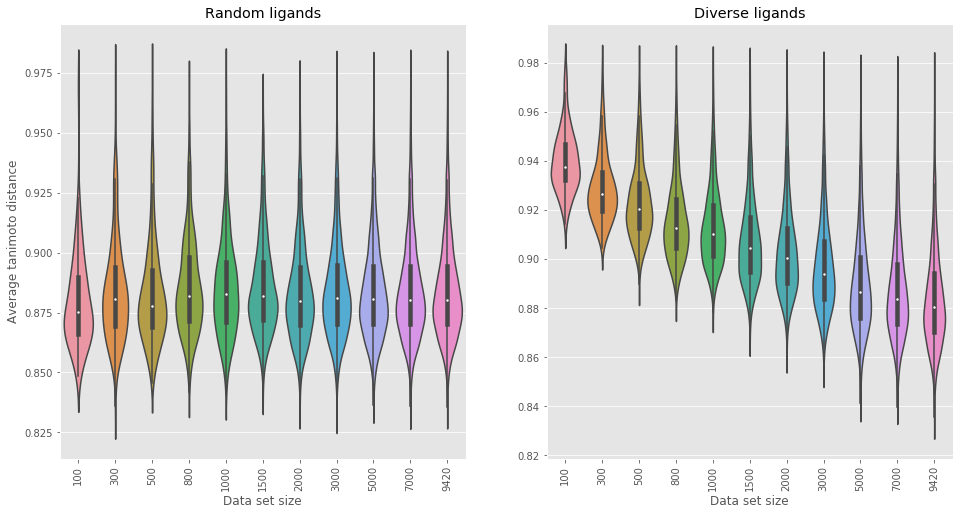

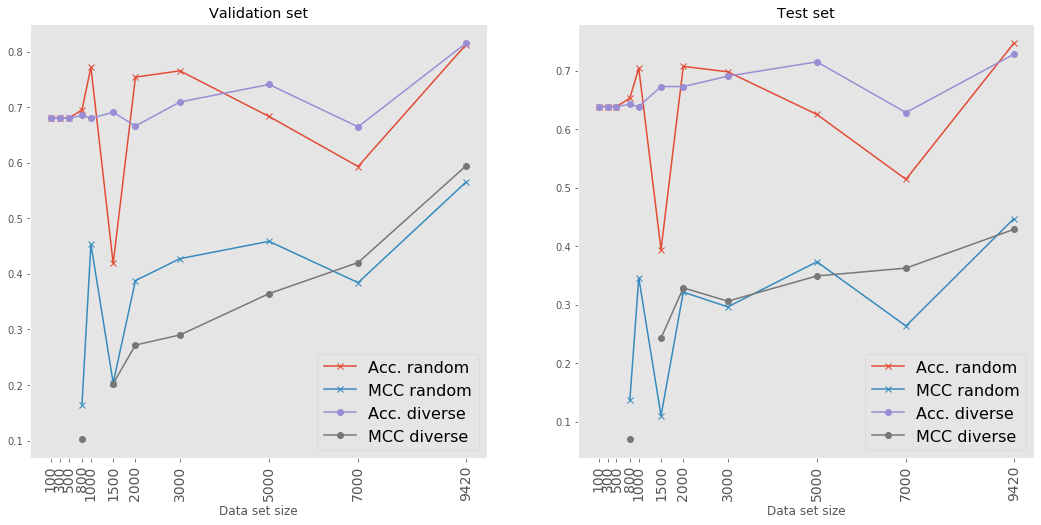

In [21]:
plot_distances(dist_random, dist_diverse)
plot_evolution(validation_random, validation_diverse, test_random, test_diverse)

MACCS with feature selection

In [22]:
hidden_layers = 4
neurons = 150
dropout = 0.2
lr = 0.001
# opt  = tf.keras.optimizers.Adam(lr=lr)
opt  = tf.keras.optimizers.Adam()
L2 = 0.001
isoform_name = "2c9"
active_rate = len(np.where(labels_2c9 == 1)[0])/len(labels_2c9)
test_random, validation_random, test_diverse, validation_diverse, dist_random, dist_diverse = test_sizes_set_features_selection(hidden_layers, neurons, dropout, opt, L2, sizes, active_rate, labels_2c9, fps_shared_MACCS, features_shared_MACCS, features_only_2c9_MACCS, labels_testing_2c9, 60)

*** Using top 60% features, 100 out of 167
Proportion actives in validation: 0.32 Proportion actives in train: 0.32
Metrics with size 100, 100, validation set, random ligands
NER: 0.629, Sensitivity or recall: 0.375, Specificity: 0.882, Precision: 0.600, Correctly classified: 0.720, MCC: 0.300
Metrics with size 100, testing set, random ligands
NER: 0.555, Sensitivity or recall: 0.438, Specificity: 0.672, Precision: 0.430, Correctly classified: 0.587, MCC: 0.109
Proportion actives in validation: 0.32 Proportion actives in train: 0.32
Metrics with size 100, 100, validation set, diverse ligands
NER: 0.540, Sensitivity or recall: 0.375, Specificity: 0.706, Precision: 0.375, Correctly classified: 0.600, MCC: 0.081
Metrics with size 100, testing set, diverse ligands
NER: 0.581, Sensitivity or recall: 0.528, Specificity: 0.635, Precision: 0.450, Correctly classified: 0.596, MCC: 0.158
Proportion actives in validation: 0.32 Proportion actives in train: 0.32
Metrics with size 300, 300, validati

Proportion actives in validation: 0.3211428571428571 Proportion actives in train: 0.32152380952380955
Metrics with size 7000, 7000, validation set, diverse ligands
NER: 0.683, Sensitivity or recall: 0.504, Specificity: 0.863, Precision: 0.635, Correctly classified: 0.747, MCC: 0.393
Metrics with size 7000, testing set, diverse ligands
NER: 0.660, Sensitivity or recall: 0.463, Specificity: 0.858, Precision: 0.648, Correctly classified: 0.715, MCC: 0.352
Proportion actives in validation: 0.3214437367303609 Proportion actives in train: 0.321585279547063
Metrics with size 9420, 9420, validation set, random ligands
NER: 0.780, Sensitivity or recall: 0.729, Specificity: 0.831, Precision: 0.672, Correctly classified: 0.798, MCC: 0.549
Metrics with size 9420, testing set, random ligands
NER: 0.723, Sensitivity or recall: 0.657, Specificity: 0.789, Precision: 0.637, Correctly classified: 0.741, MCC: 0.443
Proportion actives in validation: 0.3214437367303609 Proportion actives in train: 0.321585

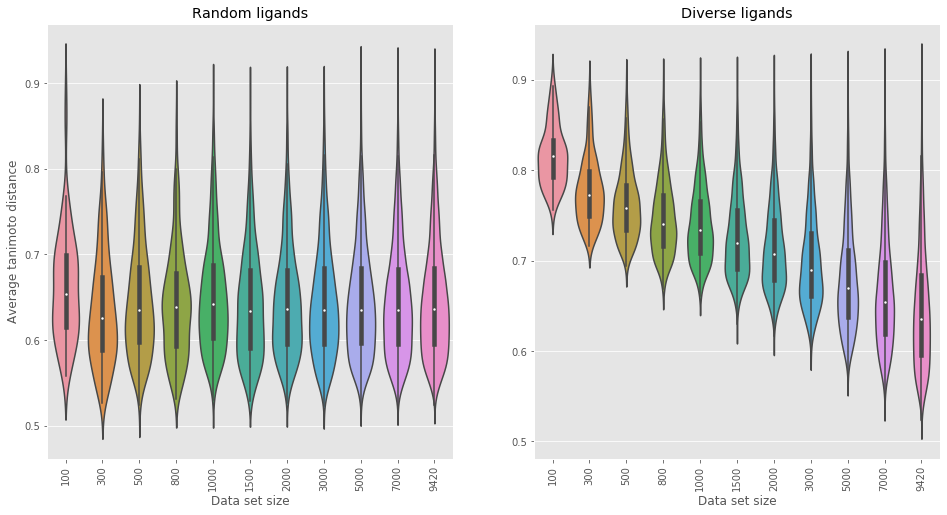

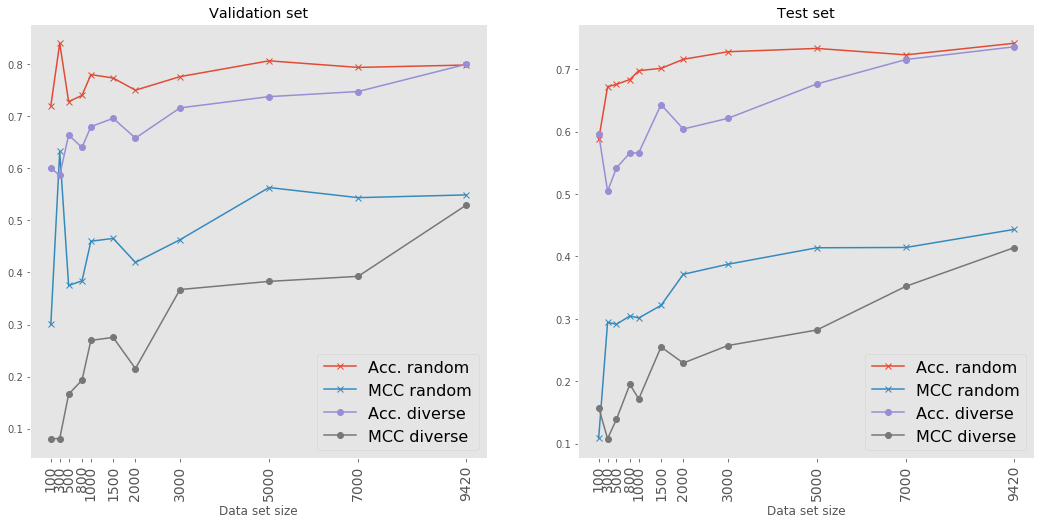

In [23]:
plot_distances(dist_random, dist_diverse)
plot_evolution(validation_random, validation_diverse, test_random, test_diverse)

RDKIT fingerprints with feature selection

In [24]:
hidden_layers = 4
neurons = 130
dropout = 0.2
lr = 0.1
opt  = tf.keras.optimizers.SGD(lr=lr)
L2 = 0.0010000

active_rate = len(np.where(labels_2c9 == 1)[0])/len(labels_2c9)
test_random, validation_random, test_diverse, validation_diverse, dist_random, dist_diverse = test_sizes_set_features_selection(hidden_layers, neurons, dropout, opt, L2, sizes, active_rate, labels_2c9, fps_shared_RDKIT, features_shared_RDKIT, features_only_2c9_RDKIT, labels_testing_2c9, 35)

*** Using top 35% features, 717 out of 2048
Proportion actives in validation: 0.32 Proportion actives in train: 0.32
Metrics with size 100, 100, validation set, random ligands
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.680, MCC: nan
Metrics with size 100, testing set, random ligands
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.639, MCC: nan


/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


Proportion actives in validation: 0.32 Proportion actives in train: 0.32
Metrics with size 100, 100, validation set, diverse ligands
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.680, MCC: nan
Metrics with size 100, testing set, diverse ligands
NER: 0.593, Sensitivity or recall: 0.768, Specificity: 0.419, Precision: 0.428, Correctly classified: 0.545, MCC: 0.188


/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


Proportion actives in validation: 0.32 Proportion actives in train: 0.32
Metrics with size 300, 300, validation set, random ligands
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.680, MCC: nan
Metrics with size 300, testing set, random ligands
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.639, MCC: nan


/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


Proportion actives in validation: 0.32 Proportion actives in train: 0.32
Metrics with size 300, 300, validation set, diverse ligands
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.680, MCC: nan
Metrics with size 300, testing set, diverse ligands
NER: 0.501, Sensitivity or recall: 0.003, Specificity: 0.999, Precision: 0.750, Correctly classified: 0.640, MCC: 0.031


/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """
/home/jfrancesc/.conda/envs/drug_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


Proportion actives in validation: 0.32 Proportion actives in train: 0.32
Metrics with size 500, 500, validation set, random ligands
NER: 0.544, Sensitivity or recall: 0.100, Specificity: 0.988, Precision: 0.800, Correctly classified: 0.704, MCC: 0.210
Metrics with size 500, testing set, random ligands
NER: 0.535, Sensitivity or recall: 0.083, Specificity: 0.988, Precision: 0.800, Correctly classified: 0.661, MCC: 0.180
Proportion actives in validation: 0.32 Proportion actives in train: 0.32
Metrics with size 500, 500, validation set, diverse ligands
NER: 0.535, Sensitivity or recall: 0.175, Specificity: 0.894, Precision: 0.438, Correctly classified: 0.664, MCC: 0.097
Metrics with size 500, testing set, diverse ligands
NER: 0.550, Sensitivity or recall: 0.689, Specificity: 0.411, Precision: 0.398, Correctly classified: 0.511, MCC: 0.099
Proportion actives in validation: 0.32 Proportion actives in train: 0.32166666666666666
Metrics with size 800, 800, validation set, random ligands
NER: 

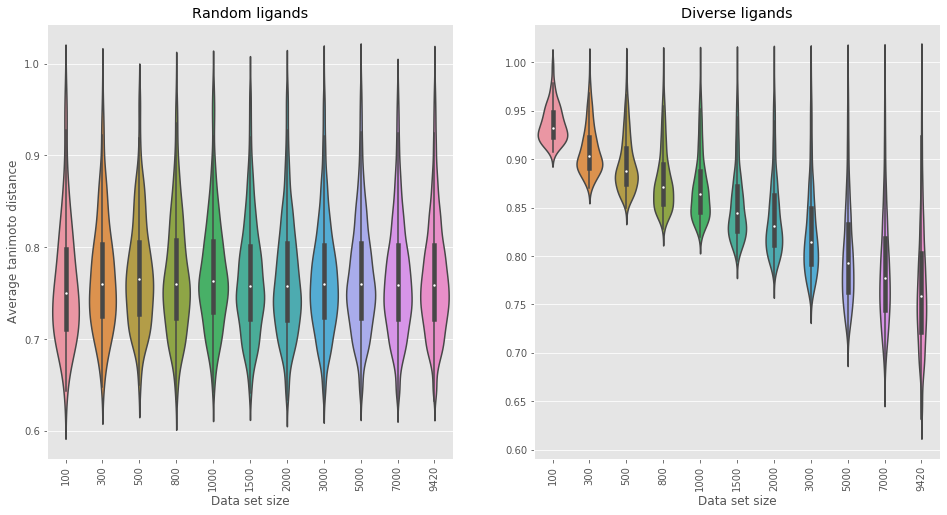

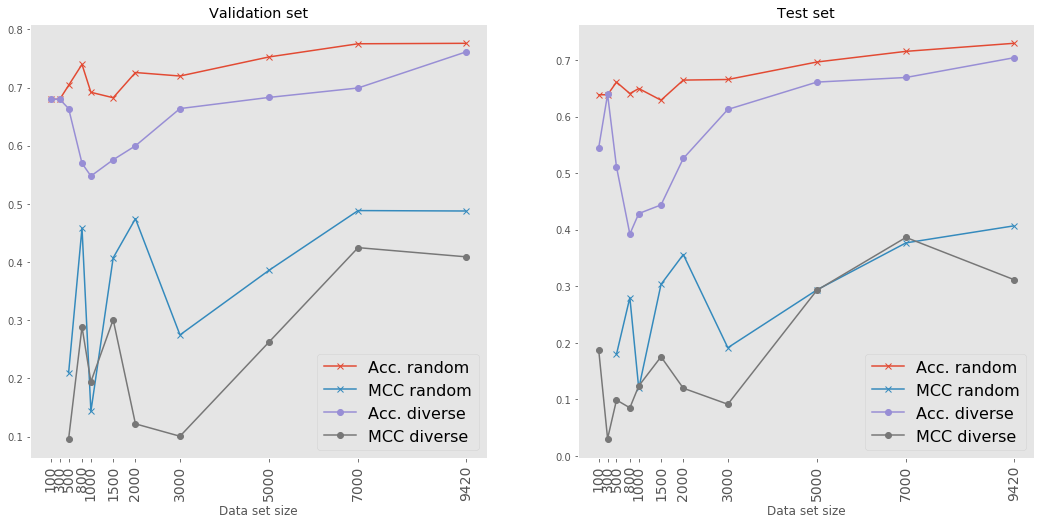

In [25]:
plot_distances(dist_random, dist_diverse)
plot_evolution(validation_random, validation_diverse, test_random, test_diverse)